In [15]:
#loading required libraries
import pickle
import pandas as pd
from random import randint
import numpy as np
import matplotlib.pyplot as plt
import time
import os,sys
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

#calling required ML models
from catboost import CatBoostClassifier

#importing preprocessing utils
from imblearn.over_sampling import RandomOverSampler

#including perfomance matrics for classification
from sklearn.metrics import confusion_matrix,accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import precision_score, recall_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, roc_auc_score, plot_roc_curve
from sklearn.metrics import precision_recall_curve

#setting display limits to maximum to view data in full scale

pd.set_option('display.max_columns', 1000)
pd.set_option('display.max_rows', 1000)

In [3]:
#reading the data
data_df=pd.read_csv('bank_marketing_model.csv')



In [4]:
#modelling with catboost, converting columns into category type

data_df['age']=data_df['age'].astype('int')
data_df['job_grouped'] = data_df['job_grouped'].astype('category')
data_df['marital'] = data_df['marital'].astype('category')
data_df['education_grouped'] = data_df['education_grouped'].astype('category')
data_df['default'] = data_df['default'].astype('category')
data_df['housing'] = data_df['housing'].astype('category')
data_df['loan'] = data_df['loan'].astype('category')
data_df['contact'] = data_df['contact'].astype('category')
data_df['month'] = data_df['month'].astype('category')
data_df['day_of_week'] =  data_df['day_of_week'].astype('category')
data_df['duration'] = data_df['duration'].astype(int)
data_df['campaign'] = data_df['campaign'].astype(int)
data_df['pdays'] = data_df['pdays'].astype(int)
data_df['previous'] = data_df['previous'].astype(int)
data_df['poutcome'] = data_df['poutcome'].astype('category')
data_df['deposit']=data_df['deposit'].astype('category')


In [5]:
#splitting the data for train test and validation
x= data_df.drop('deposit',axis=1)
y= data_df[['deposit']]
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=40)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=40)
x_train,x_eval,y_train,y_eval=train_test_split(x_train, y_train, test_size=0.2, random_state=40)

In [7]:
#oversampling to compensate for data imbalance
ros=RandomOverSampler()
x_ros,y_ros=ros.fit_resample(x_train,y_train)


----------------Train RESULTS---------------------
Accuracy of CatBoostClassifier for training: 0.9651398135818908
Precision for train set: 0.9398166800966962
Recall for train set: 0.9939280958721705

----------------VALIDATION RESULTS---------------------
Accuracy of CatBoostClassifier for training: 0.8889226100151745
Precision for validation set: 0.5
Recall for validation set: 0.755464480874317

----------------TEST RESULTS---------------------
Accuracy of CatBoostClassifier for test: 0.8871085214857976
Precision for test set: 0.5206552706552706
Recall for test set: 0.7398785425101214

               precision    recall  f1-score   support

           0       0.96      0.91      0.93      7250
           1       0.52      0.74      0.61       988

    accuracy                           0.89      8238
   macro avg       0.74      0.82      0.77      8238
weighted avg       0.91      0.89      0.90      8238



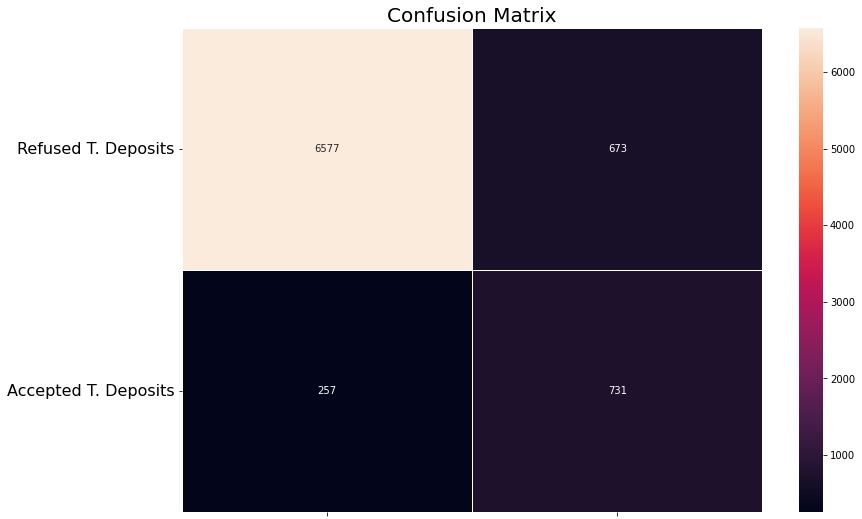

In [9]:
# Initialize CatBoostClassifier
model_cat = CatBoostClassifier(cat_features=[1,2,3,4,5,6,7,12,18,19],verbose=False) 

# Train the model
model_cat.fit(x_ros, y_ros, eval_set=(x_eval, y_eval))


# Make predictions on training data
print("\n----------------Train RESULTS---------------------")
predictions_train = model_cat.predict(x_ros)
print("Accuracy of CatBoostClassifier for training:", accuracy_score(y_ros, predictions_train))
print("Precision for train set:", precision_score(y_ros, predictions_train))
print("Recall for train set:", recall_score(y_ros, predictions_train))

# Make predictions on validation data
print("\n----------------VALIDATION RESULTS---------------------")
predictions_val = model_cat.predict(x_val)
print("Accuracy of CatBoostClassifier for training:", accuracy_score(y_val, predictions_val))
print("Precision for validation set:", precision_score(y_val, predictions_val))
print("Recall for validation set:", recall_score(y_val, predictions_val))


# Make predictions on test data
predictions_test = model_cat.predict(x_test)
print("\n----------------TEST RESULTS---------------------")
print("Accuracy of CatBoostClassifier for test:", accuracy_score(y_test, predictions_test))
print("Precision for test set:", precision_score(y_test, predictions_test))
print("Recall for test set:", recall_score(y_test, predictions_test))

# Classification report
print("\n", classification_report(y_test, predictions_test))

conf_matrix = confusion_matrix(y_test, predictions_test)
f, ax = plt.subplots(figsize=(12, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", linewidths=.5, ax=ax)
plt.title("Confusion Matrix", fontsize=20)
plt.subplots_adjust(left=0.15, right=0.99, bottom=0.15, top=0.99)
ax.set_yticks(np.arange(conf_matrix.shape[0]) + 0.5, minor=False)
ax.set_xticklabels("")
ax.set_yticklabels(['Refused T. Deposits', 'Accepted T. Deposits'], fontsize=16, rotation=360)
plt.show()


ROC AUC Score: 0.9334542789334077


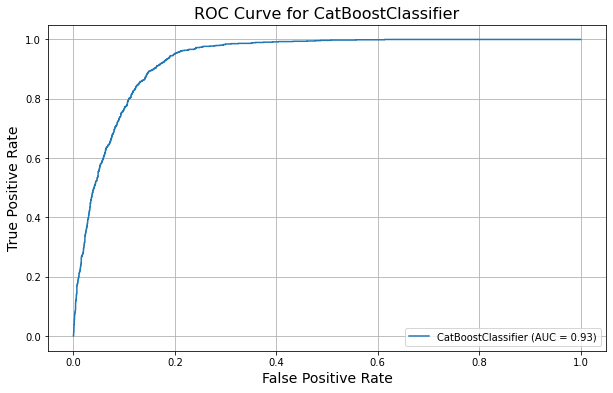

In [12]:
#roc curve
predictions_test_proba = model_cat.predict_proba(x_test)[:, 1]

# Calculate ROC AUC score
roc_auc = roc_auc_score(y_test, predictions_test_proba)
print("ROC AUC Score:", roc_auc)

# Plot ROC curve
plt.figure(figsize=(10, 6))
plot_roc_curve(model_cat, x_test, y_test, ax=plt.gca())
plt.title("ROC Curve for CatBoostClassifier", fontsize=16)
plt.xlabel("False Positive Rate", fontsize=14)
plt.ylabel("True Positive Rate", fontsize=14)
plt.grid(True)
plt.show()

[0.18178473 0.18163416 0.18166759 ... 1.         1.         1.        ] [1.         0.99898785 0.99898785 ... 0.00202429 0.00101215 0.        ]


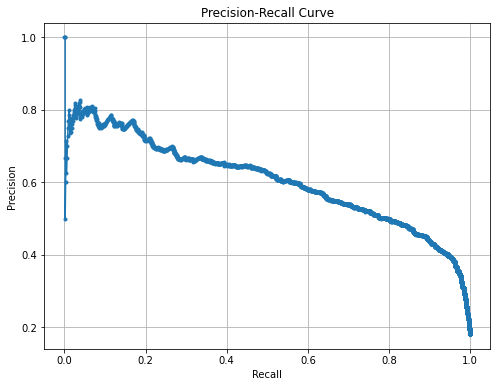

In [16]:
#precision-recall curve

precision, recall, _ = precision_recall_curve(y_test, model_cat.predict_proba(x_test)[:,1])

# Plot Precision-Recall curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, marker='.')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.grid(True)
plt.show()

In [ ]:
with open('model_catboost.pkl', 'wb') as file:
    pickle.dump(model_cat, file)